Files already downloaded and verified


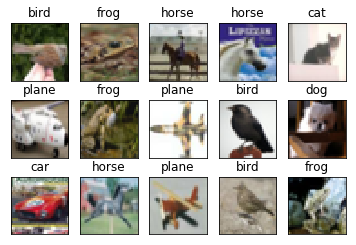

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..

Epoch: 0

Train:
[  1/391] | Loss: 2.300 | Acc: 10.938% (14/128)
[ 20/391] | Loss: 2.090 | Acc: 25.977% (665/2560)
[ 39/391] | Loss: 1.788 | Acc: 37.821% (1888/4992)
[ 58/391] | Loss: 1.671 | Acc: 43.252% (3211/7424)
[ 77/391] | Loss: 1.601 | Acc: 45.952% (4529/9856)
[ 96/391] | Loss: 1.537 | Acc: 48.527% (5963/12288)
[115/391] | Loss: 1.500 | Acc: 49.898% (7345/14720)
[134/391] | Loss: 1.446 | Acc: 51.872% (8897/17152)
[153/391] | Loss: 1.403 | Acc: 53.559% (10489/19584)
[172/391] | Loss: 1.369 | Acc: 54.742% (12052/22016)
[191/391] | Loss: 1.333 | Acc: 56.017% (13695/24448)
[209/391] | Loss: 1.308 | Acc: 56.986% (15245/26752)
[228/391] | Loss: 1.282 | Acc: 57.884% (16893/29184)
[246/391] | Loss: 1.261 | Acc: 58.689% (18480/31488)
[264/391] | Loss: 1.239 | Acc: 59.523% (20114/33792)
[282/391] | Loss: 1.219 | Acc: 60.173% (21720/36096)
[300/391] | Loss: 1.200 | Acc: 60

In [3]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import numpy as np
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import sys
import time
import math

"""필요한 Package들 import"""

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False


#Visualizing CIFAR 10
trainset = torchvision.datasets.CIFAR10(root='./data',download=True)
datanum = len(trainset)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
fig = plt.figure()
ims = np.random.randint(datanum, size=15)

for i in range(15):
    subplot = fig.add_subplot(3,5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    PILimg, label = trainset[ims[i]]
    subplot.set_title("%s" %classes[label])
    subplot.imshow(PILimg)

plt.show()



# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
net = torchvision.models.vgg16_bn(pretrained=True)
net.avgpool = nn.AdaptiveAvgPool2d((1, 1))
net.classifier = nn.Sequential(
            nn.Linear(512, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(100, 10)
        )

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/prevgg16.pt')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    print('\nTrain:')
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    print_time = -1
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if time.time()-print_time > 1 or print_time == -1 or batch_idx+1 == len(trainloader):
            print('[%3d/%3d] | Loss: %.3f | Acc: %.3f%% (%d/%d)'%(
                batch_idx+1, len(trainloader), train_loss/(batch_idx+1), 100.*correct/total, correct, total))
            
            print_time = time.time()

def test(epoch):
    print('\nTest:')
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    print_time = -1
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if time.time()-print_time > 1 or print_time == -1 or batch_idx+1 == len(testloader):
                print('[%3d/%3d] | Loss: %.3f | Acc: %.3f%% (%d/%d)'%(
                    batch_idx+1, len(testloader), test_loss/(batch_idx+1), 100.*correct/total, correct, total))
                
                print_time = time.time()
                

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/prevgg16.pt')
        best_acc = acc

    scheduler.step(test_loss/(batch_idx+1))

for epoch in range(start_epoch, start_epoch+10):
    train(epoch)
    test(epoch)

==> Building model..
==> Resuming from checkpoint..
Files already downloaded and verified
10000 test samples
accuracy:0.77270
Confusion matrix, without normalization
Normalized confusion matrix


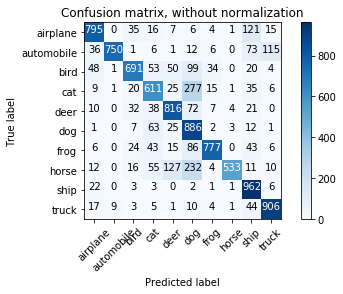

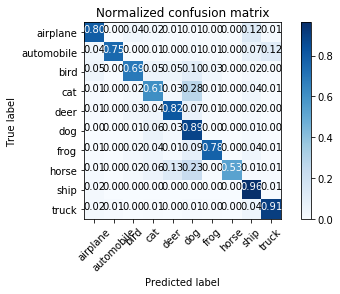

In [2]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import sklearn.metrics as skl



def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



if __name__ == '__main__':
    name_list = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    num_classes = 10


    # Load model and weights
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    print('==> Building model..')
    net = torchvision.models.vgg16_bn(pretrained=True)
    net.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    net.classifier = nn.Sequential(
        nn.Linear(512, 100),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(100, 10)
    )

    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True

    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/prevgg16.pt')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    net.eval()

    # Data
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    print(len(testset), 'test samples')

    ylabel = []
    yhatlabel = []

    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        ylabel = np.concatenate((ylabel, targets.cpu().numpy()))
        yhatlabel = np.concatenate((yhatlabel, predicted.cpu().numpy()))

    # Compute confusion matrix
    cnf_matrix = skl.confusion_matrix(ylabel, yhatlabel)
    np.set_printoptions(precision=2)
    is_correct = (ylabel == yhatlabel)
    acc = np.sum(is_correct * 1) / len(is_correct)
    print('accuracy:%.5f' %acc)


    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=name_list,
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=name_list, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

